In [1]:
from ctrade import *
from plot import *
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
p = Poloniex()

In [3]:
major = ['ETH', 'ETC', 'BCN', 'DASH', 'DOGE', 'LTC', 'NXT', 'REP', 'ZEC', 'ARDR', 'XRP', 'STR']

In [4]:
pairs = [i for i in p.currency_pairs if 'USDT_' in i]
pairs += [i for i in p.currency_pairs if any([j for j in major if 'BTC_'+j in i])]

In [5]:
inf = lambda x: np.isinf(x)

def build_dataset(currency_pairs, days_back, period):
    out = pd.DataFrame()
    for i in currency_pairs:
        print(i)
        t = p.chart(i, days_back, period).df
        t[i+'_PC'] = (t['close'] - t['close'].shift(1))/t['close']
        t = t.rename(columns={'close': i})
        t[i+'_volume'] = t['volume']
        t[i+'_volume_PC'] = (t[i+'_volume'] - t[i+'_volume'].shift(1))/t[i+'_volume']
        t[i+'_volume_PC'] = t[i+'_volume_PC'].fillna(0)
        mask = t[i+'_volume_PC'].apply(inf)
        t.loc[mask, i+'_volume_PC'] = 0
        out = pd.concat([out, t[[i+'_PC', i+'_volume_PC', i, i+'_volume']]], axis=1)
    
    df = out[currency_pairs + [i+'_volume' for i in currency_pairs]]
    out = out[out[i+'_PC'].notnull()]
    return out[[i for i in out.columns if i not in currency_pairs]], df

In [255]:
df = p.chart('BTC_LTC', 60, '15m').df
df['value'] = (df['open'] + df['close'])*0.5

This dictionary set the parameter for the indicators which I am using to build my model.
Daily or weekly pivot levels are used. 

In [256]:
indicators = {
    'macd': ('macd', {'slow_window': 50, 'fast_window': 15}),
    'rsi': ('rsi', {'window': 15}),
    'fstoc': ('fstoc', {'k_smooth': 8, 'd_smooth': 3}),
    'atr': ('atr', None),
    'bbands': ('bbands', {'mode':'spread'}),
    'pivot_daily': ('pivot', {'mode': 'day'}),
    'pivot_weekly': ('pivot', {'mode': 'week'}),
    'consecutive_periods': ('consecutive_periods', {'add_periods': ['1h', '4h']}),
}

In [257]:
class Model(object):
    
    def __init__(self, indicators, currency):
        self.indicators = indicators
        self.currency = currency
        self.indicator_func = {}
        
    def set_indicators(self):
        
        def feed(x):
            return {} if x is None else x
        
        for k,v in self.indicators.items():
            if v[0] in ['macd', 'rsi', 'bbands', 'pivot', 'consecutive_periods']:
                self.indicator_func[k] = with_series(self.currency)(indicator_partial(globals()[v[0]], **feed(v[1])))
            else:
                self.indicator_func[k] = indicator_partial(globals()[v[0]], **feed(v[1]))
        
    def get_data(self, df):
        
        return reduce(lambda x,y: pd.concat([x,y], axis=1), 
                      [func(df) for func in self.indicator_func.values()])
    
    def get_target(self, Y, span=[2, 5, 10, 25, 50, 100]):
        
        _Y = pd.DataFrame(index=Y.index)
        for s in span:
            _Y[s] = np.nan
            _Y.iloc[:-s, -1] = (Y - Y.shift(s)).iloc[s:].values
        return _Y

In [258]:
m = Model(indicators, 'value')
m.set_indicators()

This is the dataset to build the model on where all indicators are calculated at each timeframe.

In [259]:
X = m.get_data(df).dropna()
X.tail(20)

Calculating weekly pivot levels
Calculating daily pivot levels


,P_week_diff,R1_week_diff,S1_week_diff,R2_week_diff,S2_week_diff,R3_week_diff,S3_week_diff,rsi_15,bbands_20,conseq_up,...,atr_14,%D_14,%K_14,P_day_diff,R1_day_diff,S1_day_diff,R2_day_diff,S2_day_diff,R3_day_diff,S3_day_diff
2017-06-11 09:30:00,-0.000897,-0.001569,6.815500e-05,-0.002534,0.000740,-0.004171,0.002377,35.872698,0.029759,0,...,0.000081,42.126278,36.009488,-0.000011,-0.000204,0.000254,-0.000468,0.000447,-0.000925,0.000904
2017-06-11 09:45:00,-0.000918,-0.001590,4.732500e-05,-0.002555,0.000719,-0.004192,0.002356,23.027045,0.027099,0,...,0.000079,35.245977,28.617010,-0.000031,-0.000224,0.000233,-0.000489,0.000426,-0.000946,0.000883
2017-06-11 10:00:00,-0.000932,-0.001604,3.325000e-05,-0.002569,0.000705,-0.004206,0.002342,21.939897,0.026171,0,...,0.000076,28.304873,20.288120,-0.000046,-0.000238,0.000219,-0.000503,0.000412,-0.000960,0.000869
2017-06-11 10:15:00,-0.000924,-0.001596,4.084000e-05,-0.002561,0.000713,-0.004199,0.002350,21.373845,0.025704,1,...,0.000073,20.726872,13.275485,-0.000038,-0.000231,0.000227,-0.000495,0.000419,-0.000953,0.000877
2017-06-11 10:30:00,-0.000918,-0.001590,4.746000e-05,-0.002555,0.000719,-0.004192,0.002356,25.672582,0.026142,2,...,0.000073,14.360427,9.517677,-0.000031,-0.000224,0.000233,-0.000489,0.000426,-0.000946,0.000884
2017-06-11 10:45:00,-0.000900,-0.001572,6.485000e-05,-0.002537,0.000737,-0.004175,0.002374,31.622446,0.026905,3,...,0.000073,10.893260,9.886619,-0.000014,-0.000207,0.000251,-0.000471,0.000443,-0.000929,0.000901
2017-06-11 11:00:00,-0.000922,-0.001594,4.310000e-05,-0.002559,0.000715,-0.004196,0.002352,25.207447,0.027316,0,...,0.000074,9.772736,9.913912,-0.000036,-0.000229,0.000229,-0.000493,0.000422,-0.000951,0.000879
2017-06-11 11:15:00,-0.000965,-0.001637,2.400000e-07,-0.002602,0.000672,-0.004239,0.002309,22.308274,0.028522,0,...,0.000075,10.257850,10.973019,-0.000079,-0.000271,0.000186,-0.000536,0.000379,-0.000993,0.000836
2017-06-11 11:30:00,-0.000950,-0.001622,1.522500e-05,-0.002587,0.000687,-0.004224,0.002324,20.923623,0.028441,1,...,0.000073,11.160174,12.593592,-0.000064,-0.000256,0.000201,-0.000521,0.000394,-0.000978,0.000851
2017-06-11 11:45:00,-0.000925,-0.001597,4.033000e-05,-0.002562,0.000712,-0.004199,0.002349,25.634248,0.028176,2,...,0.000070,13.261951,16.219242,-0.000038,-0.000231,0.000226,-0.000496,0.000419,-0.000953,0.000876


Here I am calculating the price difference of the crypto pair at different periods to build the model. You can see here I am using 2, 5, 10, 25, 50 and 100 periods.

In [260]:
Y = m.get_target(df['value']).dropna()
Y.tail(20)

,2,5,10,25,50,100
2017-06-10 08:30:00,0.000001,-0.000021,-0.000110,-0.000200,-1.838050e-04,-0.000146
2017-06-10 08:45:00,0.000035,-0.000010,-0.000138,-0.000191,-1.552450e-04,-0.000149
2017-06-10 09:00:00,-0.000002,-0.000011,-0.000162,-0.000186,-1.517650e-04,-0.000182
2017-06-10 09:15:00,-0.000038,-0.000043,-0.000183,-0.000176,-1.250650e-04,-0.000191
2017-06-10 09:30:00,-0.000027,-0.000060,-0.000143,-0.000138,-1.044200e-04,-0.000166
2017-06-10 09:45:00,0.000011,-0.000089,-0.000075,-0.000119,-8.519000e-05,-0.000129
2017-06-10 10:00:00,0.000002,-0.000128,-0.000026,-0.000066,-9.744000e-05,-0.000143
2017-06-10 10:15:00,-0.000051,-0.000151,-0.000067,-0.000069,-9.560500e-05,-0.000204
2017-06-10 10:30:00,-0.000084,-0.000140,-0.000126,-0.000059,-8.893000e-05,-0.000174
2017-06-10 10:45:00,-0.000095,-0.000083,-0.000184,-0.000066,-9.117500e-05,-0.000113


In [261]:
X_train = X.iloc[:-1000]
Y_train = Y.iloc[:-1000]
X_test = X.iloc[-1000:]
Y_test = Y.iloc[-1000:]


In [262]:
mask = Y_train.index.isin(X_train.index)
Y = Y_train[mask]

mask = X_train.index.isin(Y.index)
save_last = X_train[~mask] 
X = X_train[mask]

In [263]:
X.shape[0], Y.shape[0], save_last.shape[0]

(4238, 4238, 100)

Here I am choosing to build the first model using the 5 period value difference (aka the price difference from each timeframe and that of 5 period later, 1h15m)

In [264]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from model_utils import *
from preprocessing import *

if len(Y[5].unique())>2:
    est = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, max_depth=4)
    est = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=4)
else:
    est = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, max_depth=3)
    est = GradientBoostingClassifier(n_estimators=20, min_samples_leaf=10, max_depth=4)   

res = do_easy_crossval(est, X, Y[5]*1000, folds=10, refit=True)
pred = res[0]
est = res[1]

Trained fold 1
Trained fold 2
Trained fold 3
Trained fold 4
Trained fold 5
Trained fold 6
Trained fold 7
Trained fold 8
Trained fold 9
Trained fold 10


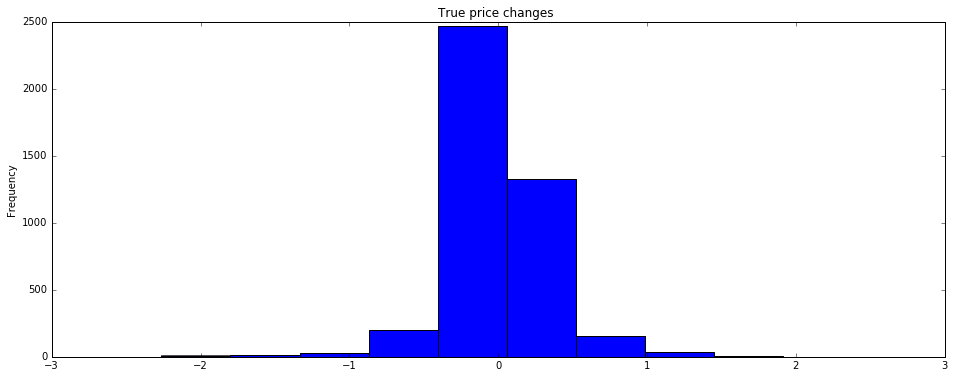

In [265]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
pred['true'].plot(kind='hist', ax=ax)
ax.set_title('True price changes ')

0.68272536887712931

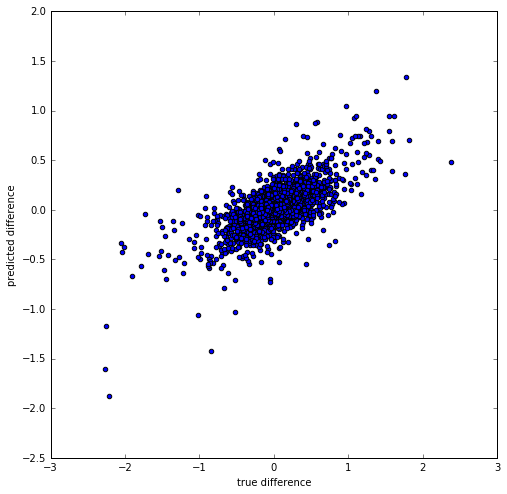

In [266]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(pred['true'], pred['pred'])
ax.set_xlabel('true difference')
ax.set_ylabel('predicted difference')

np.corrcoef(pred['true'], pred['pred'])[0][1]

The correlattion between the change in the cryptocurrency value and the predicted one is quite good as you can see from the scatter plot. Note that the predicted value are always out of sample and the model was not build on the point where it is predicting.

Below you can see which are the indicators sorted by there contribution to the overall prediction.

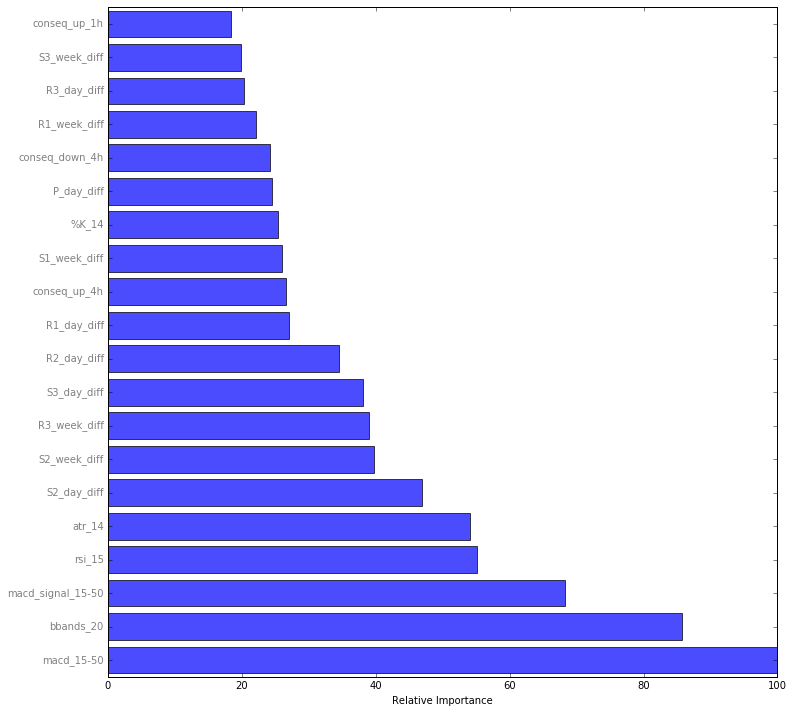

In [267]:
plot_feature_importances(est, X.columns, top=20)

Ideally one would use a combination of the predicted differences at different timeframes to base the buy-sell strategy.

I am going to add to this the following:
    * same indicators for another cryptocurrency, such as USD_BCT as I thing there is signal also there
    * Wrap mode that one model together and calibrate
    * Create a probabilistic model to output a probability
    

In [268]:
class StackModels(object):
    
    def __init__(self, estimator):
        self.estimator = estimator
        self.fitted_estimators = []
        self.oob_predictions = []
        self.labels = []
        
    def fit(self, X, Y):
                
        for col in Y.columns:
            res = do_easy_crossval(self.estimator, X, Y[col]*1000, folds=10, refit=True, plot=False)
            self.fitted_estimators.append(copy.deepcopy(res[1]))
            self.oob_predictions.append(res[0].sort_index()
                                        .rename(columns={k:'{}_{}'.format(k, col) for k in res[0].columns}))
            self.labels.append('pred_{}'.format(col))
            
    def predict(self, X):
    
        predictions = []
    
        for iest,est in enumerate(self.fitted_estimators):
            
            pred = pd.DataFrame(est.predict(X), index=X.index, columns=[self.labels[iest]])
            predictions.append(pred)
            
        return pd.concat(predictions, axis=1)
            
    def stack_predictions(self):
    
        out = self.oob_predictions[0]
        columns = [i for i in out.columns if 'pred' in i]
        out = out[columns]
        for df in self.oob_predictions[1:]:
            columns = [i for i in df.columns if 'pred' in i]
            out = out.join(df[columns], how='inner')
            
        return out.dropna()

In [269]:
stack = StackModels(est)

stack.fit(X, Y)

In [270]:
stack.fitted_estimators[0] is stack.fitted_estimators[1]

False

In [271]:
class Signals(object):
    
    def __init__(self):
    
        self.quantiles = {}

    def fit(self, X):
        
        for col in X.columns:
            df, Q = tag_ranges(X, col, quantiles=(0.3, 0.7))
            self.quantiles[col] = Q
    
        signal_tags = [i for i in X.columns if 'tag' in i]
        X['main'] = X[signal_tags].sum(axis=1)
        X['signal'] = 0
        mask = X['main'] >3
        X.loc[mask, 'signal'] = 1
        mask = X['main'] <-3
        X.loc[mask, 'signal'] = -1

        return X
    
    @staticmethod
    def apply_tag(df, column, Q):
        
        df[column+'_tag'] = 0
        mask = df[column]<Q[0]
        df.loc[mask, column+'_tag'] = -1
        mask = df[column]>Q[1]
        df.loc[mask, column+'_tag'] = 1
        
        return df
    
    def predict(self, X):
        
        for col in X.columns:
            
            X = self.apply_tag(X, col, self.quantiles[col])
            
        signal_tags = [i for i in X.columns if 'tag' in i]
        X['main'] = X[signal_tags].sum(axis=1)
        
        X['signal'] = 0
        mask = X['main'] >3
        X.loc[mask, 'signal'] = 1
        mask = X['main'] <-3
        X.loc[mask, 'signal'] = -1

        return X

In [272]:
U = stack.stack_predictions()
signals = Signals()
U = signals.fit(U)

(-0.029934717822600494, 0.025755154212613783)
(-0.056132753240098289, 0.041727980953098549)
(-0.085649678303525073, 0.063148652517066084)
(-0.16313138030652011, 0.12372320462028914)
(-0.27028103354425803, 0.19155534830269053)
(-0.50860245943442117, 0.30890013644847708)


In [273]:
price = U.join(df[['value']], how='inner')['value']
a, b, c = simulate_buy_sell(U['signal'].tolist(), price.tolist(), U.index.tolist())

B 0.00989616
CB 0.010461195 0.0570963889024
S 0.010480625
CS 0.00845518 0.193256127378
B 0.00854647
CB 0.012709995 0.487163121148
S 0.01275887
CS 0.01186498 0.0700602796329
B 0.011838385
CB 0.012525045 0.0580028441379
S 0.0124474
CS 0.011484545 0.0773539052332
B 0.011474905
CB 0.012174545 0.0609713108736
S 0.01217001
CS 0.010416485 0.144085748492
B 0.01051003
CB 0.011858685 0.128320756458
B 0.01159159
CB 0.012100115 0.0438701679407
S 0.012088535
CS 0.01087432 0.100443519417
B 0.010629415
CB 0.011114495 0.0456356252908
B 0.0107864
CB 0.017415 0.614533115775
S 0.0172877
CS 0.016554995 0.0423830237683
B 0.01640675
CB 0.017310995 0.0551142060432
B 0.01707852
CB 0.019639 0.149923998098
S 0.01966668
CS 0.01576254 0.198515458634
B 0.01518
CB 0.01939899 0.27793083004
S 0.01942249
CS 0.018395005 0.0529018163994
B 0.017998685
CB 0.021704155 0.205874484719
S 0.02161567
CS 0.0164444 0.2392370905
B 0.015991335
CB 0.017315 0.0827738897347
S 0.017320955
CS 0.01642668 0.0516296589882
B 0.016655005
CB 

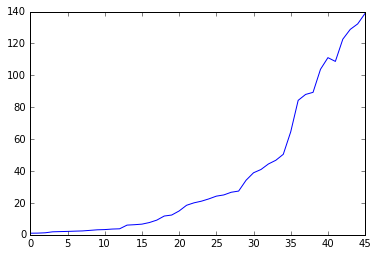

In [274]:
res = pd.DataFrame(np.array([0] + b[1:])+1, index=range(len(b)), columns=['perf'])
res['pnl'] = res['perf'].cumprod()
plt.plot(range(len(res)), res['pnl'])

In [275]:
trades = pd.DataFrame(c[:-1], columns=['trade', 'open', 'close'])
trades_sell = trades[trades['trade'] == 'S']
trades_bought = trades[trades['trade'] == 'B']

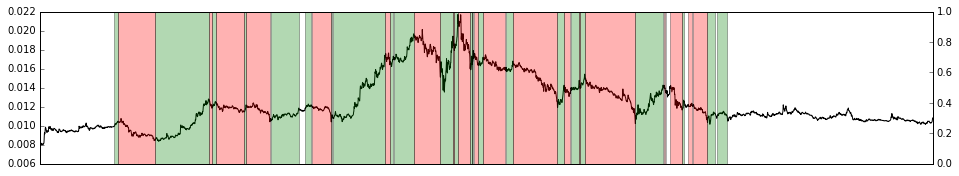

In [276]:
fig = plt.figure(figsize=(16,6))
# fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax = plot_fts(df, 'value', ax=ax, plot_args={'color': 'black'})

ax = ax.twinx()

ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]

opened = [df.index.get_loc(i) for i in trades_bought['open']]
closed = [df.index.get_loc(i) for i in trades_bought['close']]

for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='g', alpha=.3 )

opened = [df.index.get_loc(i) for i in trades_sell['open']]
closed = [df.index.get_loc(i) for i in trades_sell['close']]
for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='r', alpha=.3 )

In [277]:
test_pred = stack.predict(X_test)

In [278]:
test_pred = signals.predict(test_pred)

In [279]:
price = test_pred.join(df[['value']], how='inner')['value']
a, b, c = simulate_buy_sell(test_pred['signal'].tolist(), price.tolist(), test_pred.index.tolist())

B 0.011169995
CB 0.011970625 0.0716768449762
S 0.012200185
CS 0.010946255 0.102779588998
B 0.011056415


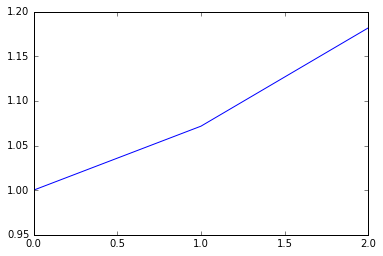

In [280]:
res = pd.DataFrame(np.array([0] + b[1:])+1, index=range(len(b)), columns=['perf'])
res['pnl'] = res['perf'].cumprod()
plt.plot(range(len(res)), res['pnl'])

In [281]:
trades = pd.DataFrame(c[:-1], columns=['trade', 'open', 'close'])
trades_sell = trades[trades['trade'] == 'S']
trades_bought = trades[trades['trade'] == 'B']

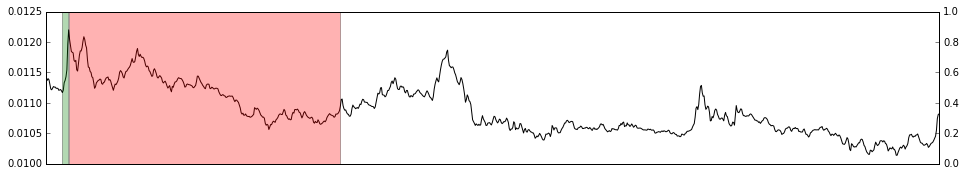

In [282]:
price = price.to_frame('value')

fig = plt.figure(figsize=(16,6))
# fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax = plot_fts(price, 'value', ax=ax, plot_args={'color': 'black'})

ax = ax.twinx()

ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]

opened = [price.index.get_loc(i) for i in trades_bought['open']]
closed = [price.index.get_loc(i) for i in trades_bought['close']]

for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='g', alpha=.3 )

opened = [price.index.get_loc(i) for i in trades_sell['open']]
closed = [price.index.get_loc(i) for i in trades_sell['close']]
for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='r', alpha=.3 )